# Assignment
*  In this assignment, we will build a classifier for MNIST from scratch using just [NumPy](https://numpy.org/)

*  [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits of size 28x28

*  The dataset that you are expected to use for training is already uploaded along

*   Our model will have 1 hidden layer, like the one below (not our recommendation to use 256 in the hidden layer though, try various values out)

**Feel free to redefine any function signatures below, just make sure the final cell remains the same.**

<center>
<img src="https://user-images.githubusercontent.com/81357954/166119893-4ca347b8-b1a4-40b8-9e0a-2e92b5f164ae.png">
</center>

## Import libraries here
NumPy, Matplotlib, ...

Also remember to initialize the seed for reproducibility of results

In [237]:
import pickle 
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import math

## Load *Dataset*
Load data from the given pickle file

In [238]:
data_file="MNIST_data.pkl"
# load the data set
with open(data_file,'rb') as infile:
    train_dataset = pickle.load(infile)
X = train_dataset['X']
y = train_dataset['y']
#Z-score normalization
standard_deviation=np.std(X,axis=0,keepdims=True)
mean=np.mean(X,axis=0,keepdims=True)
normalised_X=(X-mean)/(standard_deviation+1e-7)
# Split into X_train, y_train, X_test, y_test
X_train, X_test, y_train, y_test = train_test_split(normalised_X, y, test_size=0.50, random_state=42, stratify=y)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/text.py:1241: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


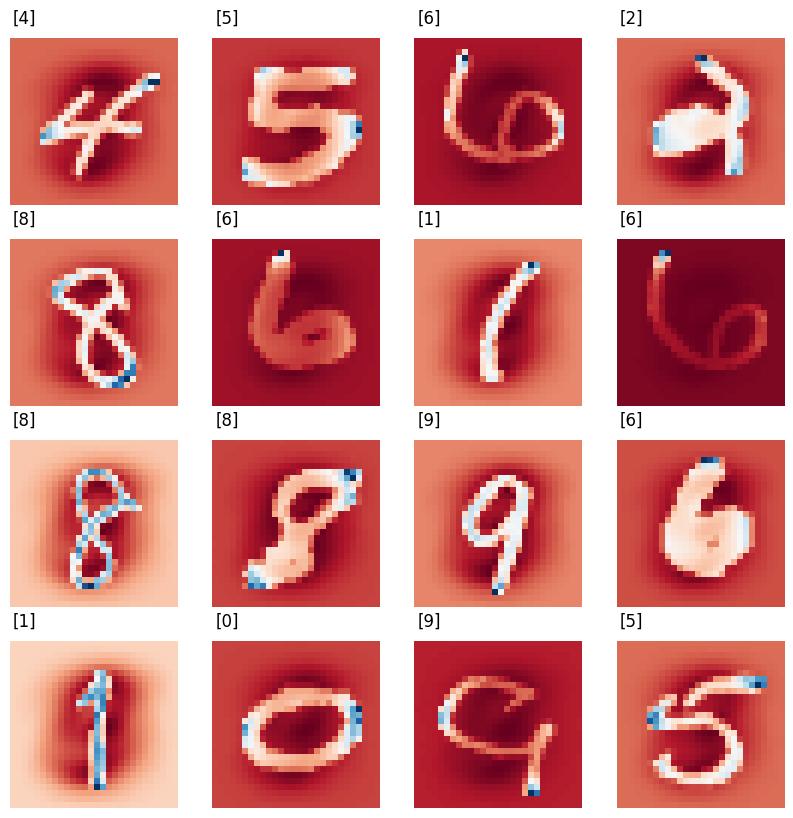

In [239]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    a=random.randint(0,30000)
    images = X_train[a]
    pixels=images.reshape((28,28))
    ax.imshow(pixels,cmap='RdBu')
    ax.axis('off')
    ax.text(0,-3,y_train[a],fontsize=12)
plt.show()
# display a 4x4 grid, 
# choose 16 images randomly, display the images as well as corresponding labels


## Building up parts of our classifier

**Activation functions**

In [240]:
def relu(z,N,p):
    for i in range(N):
        for j in range(p):
            if z[i][j]<=0:
                z[i][j]=0
    return z
def softmax(z):
    reduced=z-np.max(z,axis=1,keepdims=True)
    a =np.exp(reduced)
    b=np.sum(a,axis=1,keepdims=True)
    softmax=a/b
    return softmax 

**Notes about the Neural Network** 
*   Input size is (784,) because 28x28 = 784
*   Output size will be 10, each element represeting probability of the image representing that digit
*   Size of the hidden layer is a hyperparameter



**Initialize the layers weights**

Generally, we follow the convention that weights are drawn from a standard normal distribution, while the bias vectors are initialized to zero. But you can try everything out :)

In [246]:
def init_params(s_l1,s_l2,s_l3,N):
    W0=np.random.randn(s_l1,s_l2)/math.sqrt(s_l1+s_l2/2)
    W1=np.random.randn(s_l2,s_l3)/math.sqrt(s_l2+s_l3/2)
    b0=np.zeros((s_l2,1))
    b1=np.zeros((s_l3,1))
    return W0,W1,b0,b1

**Forward Propagation**

In [247]:
def forward_propg(X,W0,W1,b0,b1,N,l2):
    """
    X: input data
    returns: logits, output of each layer z1,z2,a1,a2
    """
    f1=(X.dot(W0))+b0.T
    X1=relu(f1,N,l2)
    f2=(X1.dot(W1))+b1.T
    X2=softmax(f2)
    return X2,X1,f1

**Backward Propagation**


You may use stochastic gradient descent or batch gradient descent here. Feel free to use any loss function.

In [248]:
def backward_propg(W0, W1, b0, b1, X, y, X2, X1, f1, N, l2, lr):
    """
    should update the weights and return updated weights
    """
    dLdf2=X2/N
    for i in range(N):
        for j in range(10):
            if j==y[i]:
                dLdf2[i][j]-=1/N
    dLdW1=(X1.T).dot(dLdf2)
    dLdB1=dLdf2
    for j in range(10):
        sum=0
        for i in range(N):
            sum+=dLdB1[i][j]
        b1[j]-=sum
    dLdX1=dLdf2.dot(W1.T)
    dLdf1=np.zeros((N, l2))
    for i in range(N):
        for j in range(l2):
            if X1[i][j]>0:
                dLdf1[i][j]=dLdX1[i][j]
    dLdW0=(X.T).dot(dLdf1)
    dLdB0=dLdf1
    for i in range(256):
        sum=0
        for j in range(N):
            sum+=dLdB0[j][i]
        b0[i]-=lr*sum
    dLdX=dLdf1.dot(W0.T)  
    W0-=lr*dLdW0
    W1-=lr*dLdW1
    return W0, W1, b0, b1

In [249]:
def cost_func(z,y,N):
    b=np.sum(z,axis=1)
    loss=0
    for i in range(N):
        c=y[i]
        d=z[i][c]
        margins=-math.log(d/b[i])
        loss+=margins
    loss=loss/N
    return loss


## Integrate everything

In [250]:
def train(X, y, l2, epochs=1000, lr=1):
    """
    hidden_nodes: no. of nodes in hidden layer

    should return the updated optimize weights.
    """
    # initialize weights.
    W0, W1, b0, b1= init_params(784, l2, 10, 30000)
    for i in range(epochs):
        # forward propagation
        X2, X1, f1= forward_propg(X, W0, W1, b0, b1, 30000, l2)
        # print cost at every 100 or so iterations
        if ((i%10)==0):
           print(cost_func(X2, y, 10000))
        # backward propagation
        W0, W1, b0, b1=backward_propg(W0, W1, b0, b1, X, y, X2, X1, f1, 30000, l2, lr) 
    return W0, W1, b0, b1

W0, W1, b0, b1= train(X_train, y_train, 256)

2.3079457377500647
0.43298341170264076
0.2262013697681744
0.1873673491401177
0.16112108960044963
0.14141627809870844
0.1258229383549264
0.11302915258391884
0.10229569623927971
0.09316789136262459
0.08526770187774818
0.07839267470206546
0.07236355351075441
0.0670232610413657
0.06224855606247572
0.057950210872768956
0.0540660248939333
0.050549460918798694
0.04735342840434169
0.04442934559935485
0.04175385937949087
0.03930394273033488
0.03704833830025142
0.034977427822369574
0.033072022883904005
0.03131122944838883
0.029676811458450608
0.028161018179365685
0.026752426213199704
0.025444453829369884
0.024225161372251218
0.02308647502162549
0.022028504263622274
0.021041915720363707
0.02011744903697502
0.01925173782407823
0.018438415125908183
0.017675692904726738
0.016960591055348927
0.016288412809992988
0.015657743127277517
0.015064139560290252
0.014505270795635709
0.013977716920857086
0.013479633727790473
0.013008735544047233
0.0125630302594487
0.012139898056833303
0.011737862954112539
0.01

In [251]:
def predict(X,W0,W1,b0,b1,N):
    hidden_scores=X.dot(W0)+b0.T
    hidden=relu(hidden_scores,N,256)
    final_scores=hidden.dot(W1)+b1.T
    final=softmax(final_scores)
    max_index=np.argmax(final,axis=1)
    return max_index

In [252]:
def accuracy(prediction, y):
    count=0
    for i in range(30000):
        if prediction[i]==y[i]:
            count=count+1
    accuracy=count/30000
    percentage_accuracy=accuracy*100
    return percentage_accuracy

In [253]:
prediction=predict(X_test,W0,W1,b0,b1,30000)
print(accuracy(prediction,y_test))

96.52666666666667


### Save as pickle

In [256]:
import pickle
import random

roll_num = "22B0932" # enter ldap
hidden_dim = 256 # replace with your own hidden dimension

model_dict = {
    'z': hidden_dim, # hidden dimension of your model
    'layer_0_wt': W0, # layer 0 weight (784, z)
    'layer_0_bias': b0, # layer 0 bias (z, 1)
    'layer_1_wt': W1, # layer 1 weight (z, 10)
    'layer_1_bias': b1 # layer 1 bias (10, 1)
}

assert model_dict['layer_0_wt'].shape == (784, hidden_dim)
assert model_dict['layer_0_bias'].shape == (hidden_dim, 1)
assert model_dict['layer_1_wt'].shape == (hidden_dim, 10)
assert model_dict['layer_1_bias'].shape == (10, 1)

with open(f'model_{roll_num}.pkl', 'wb') as f:
    pickle.dump(model_dict, f)